In [1]:
!python -m pip install statsmodels



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

c:\Users\ejvia\Documents\Máster Universidad Navarra\TFM\code\TFM-US-PREDICTION\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_excel('dataframe.xlsx')
df['date'] = pd.to_datetime(df['date'])


FileNotFoundError: [Errno 2] No such file or directory: 'dataframe.xlsx'

In [ ]:
df

,date,VIX,Unemployment,Interest_Rates,YIC,M2 MONEY STOCK,PER CAPITA CONSUMPTION,CONSUMER PRICE INDEX,SP500,USREC
0,1993-02-01,13.72,7.1,3.03,2.16,3414.5,65.557,143.100,44.406250,0
1,1993-03-01,13.61,7.0,3.07,2.03,3411.7,65.700,143.600,45.187500,0
2,1993-04-01,12.84,7.1,2.96,2.13,3411.3,65.891,144.000,44.031250,0
3,1993-05-01,13.61,7.1,3.00,2.06,3436.9,66.114,144.200,45.218750,0
4,1993-06-01,12.52,7.0,3.04,1.80,3442.4,66.177,144.400,45.062500,0
...,...,...,...,...,...,...,...,...,...,...
370,2023-12-01,12.72,3.7,5.33,-0.44,20754.0,120.305,306.746,475.309998,0
371,2024-01-01,13.39,3.7,5.33,-0.26,20754.2,120.909,308.417,482.880005,0
372,2024-02-01,13.98,3.9,5.33,-0.34,20748.6,121.231,310.326,508.079987,0
373,2024-03-01,13.79,3.8,5.33,-0.38,20841.2,121.615,312.332,523.070007,0


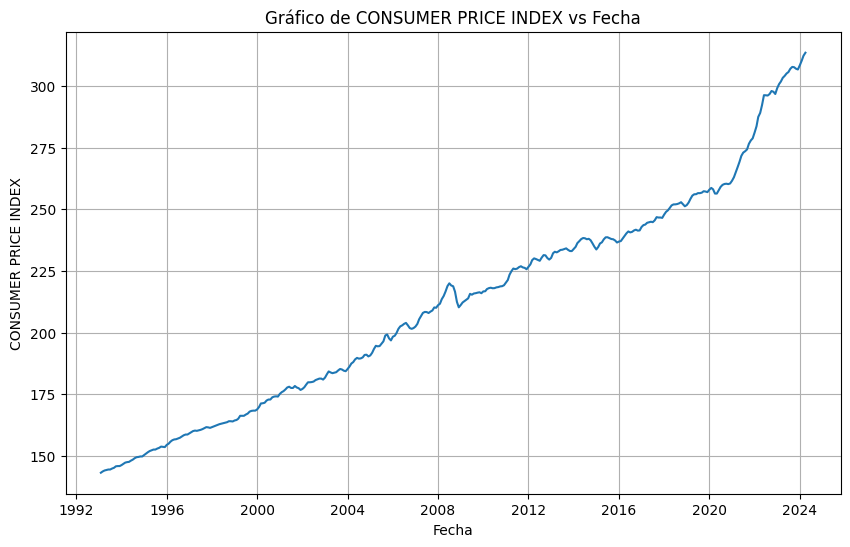

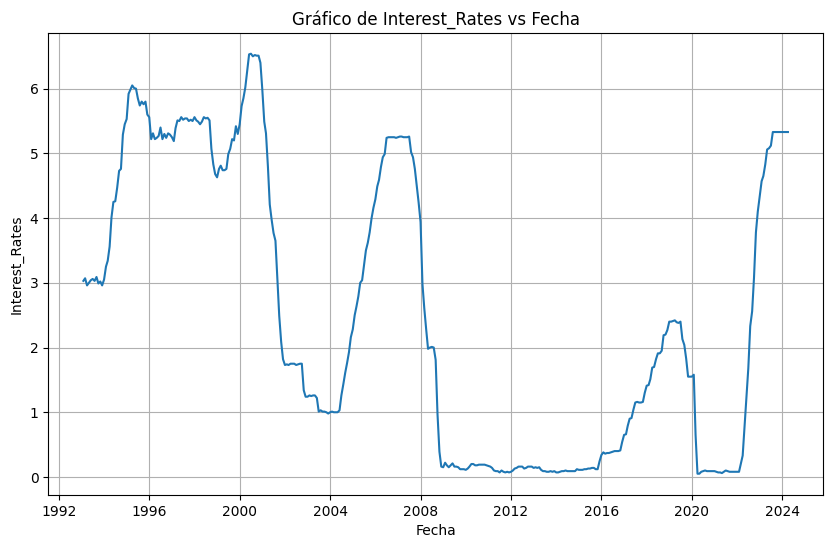

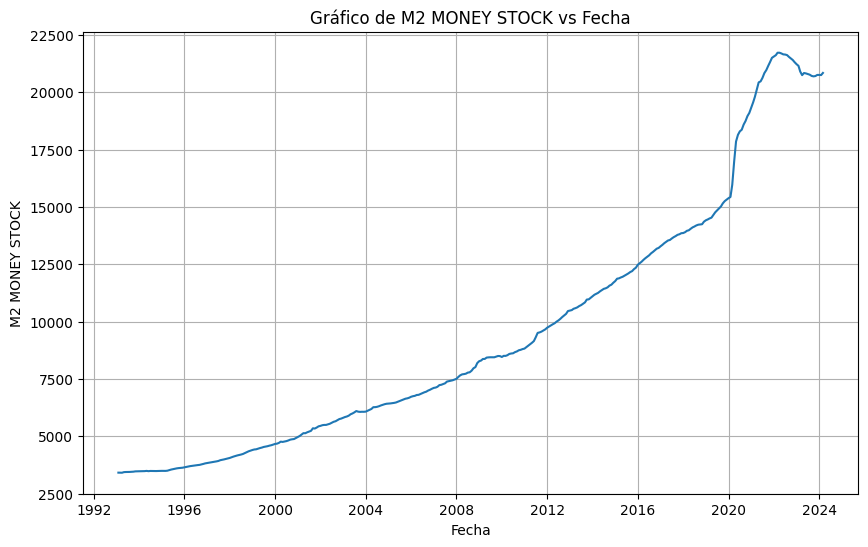

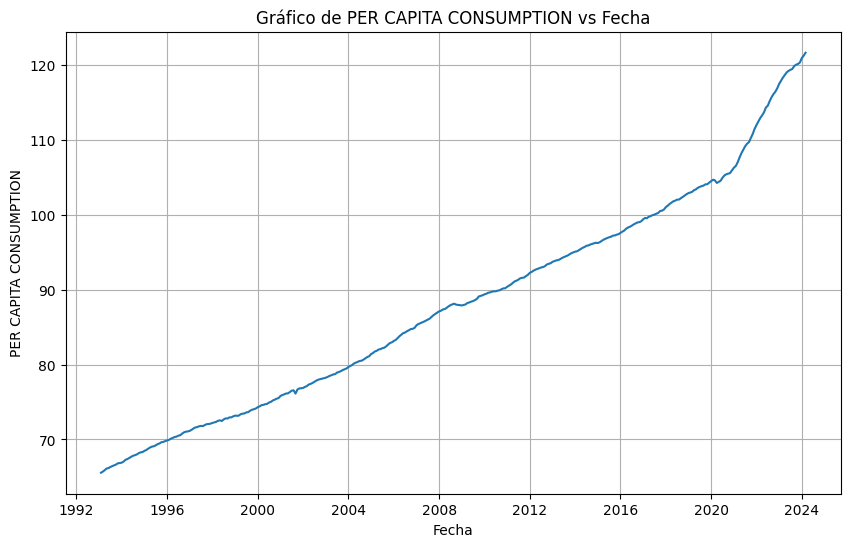

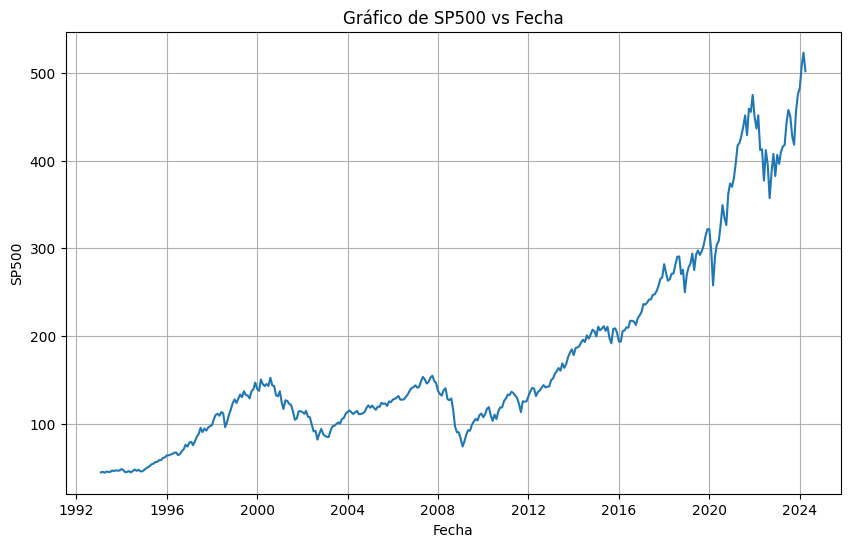

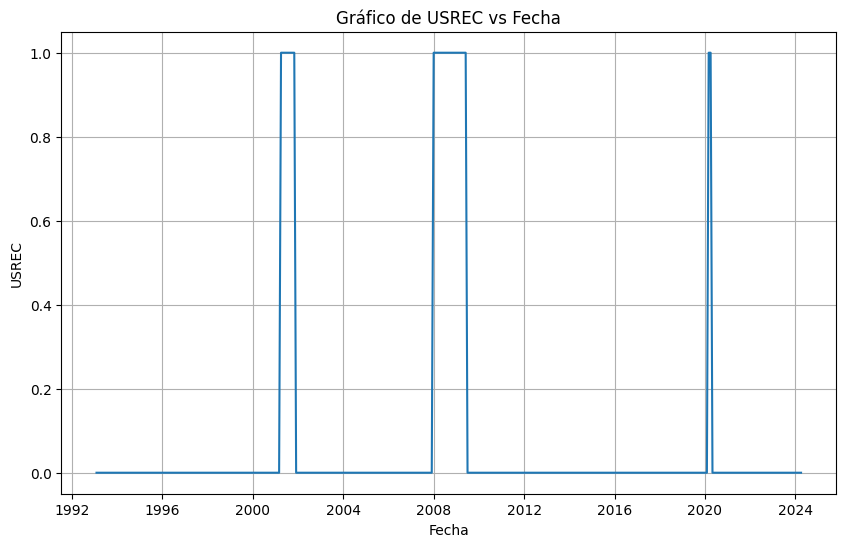

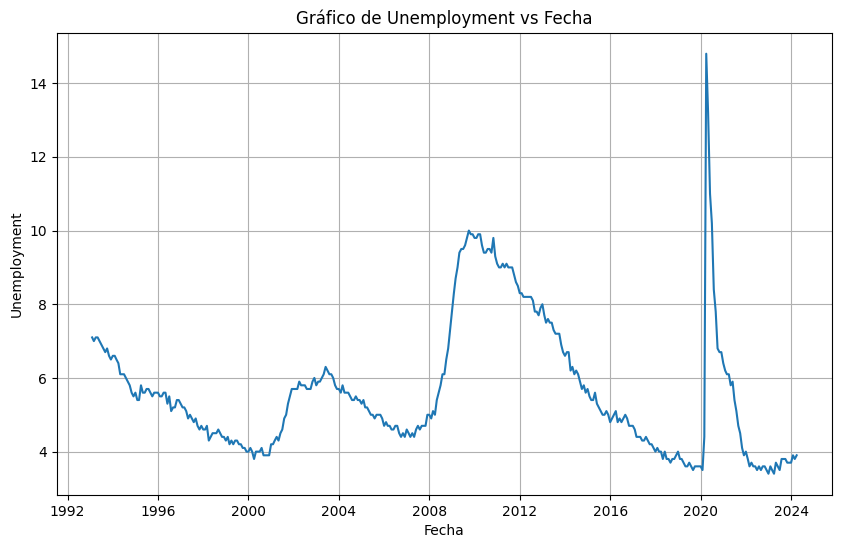

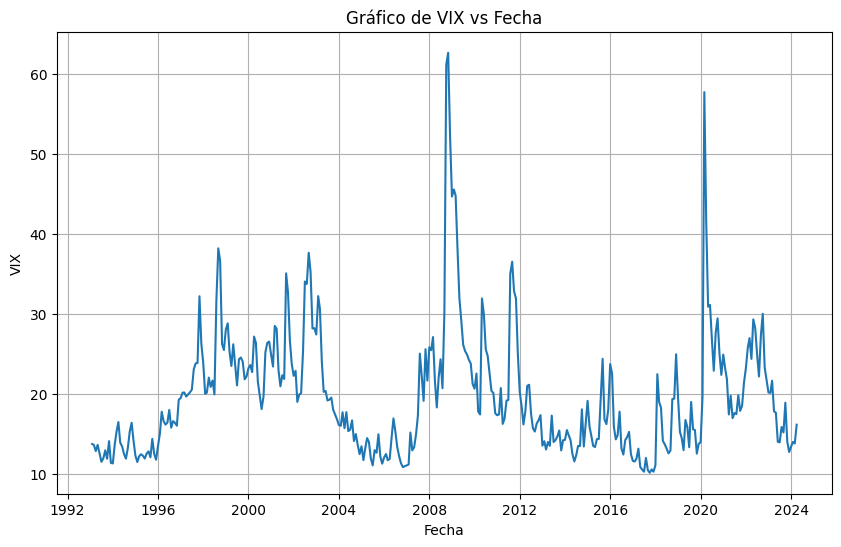

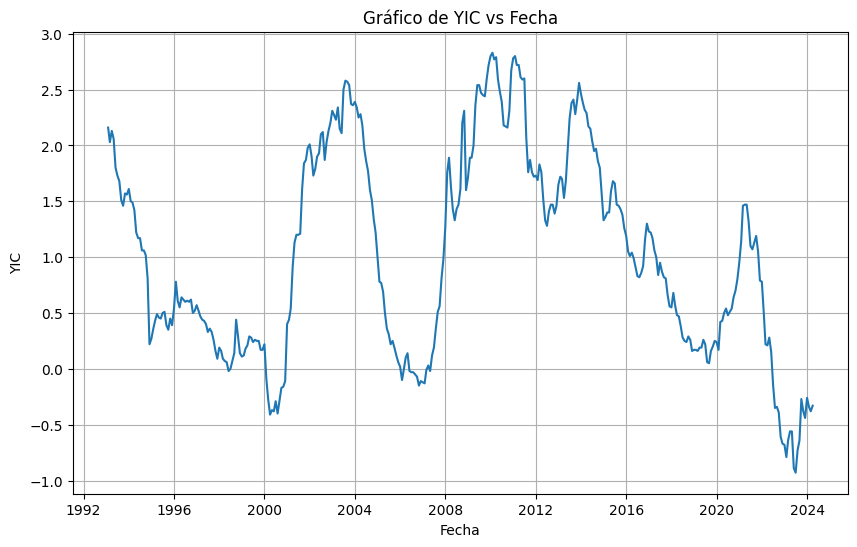

In [ ]:
columns_to_plot = df.columns.difference(['date'])

# Graficar cada columna en un gráfico individual
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'], df[column])
    plt.xlabel('Fecha')
    plt.ylabel(column)
    plt.title(f'Gráfico de {column} vs Fecha')
    plt.grid(True)
    plt.show()

In [ ]:
vix_prophet = pd.DataFrame()
vix_prophet['ds'] = df['date']
vix_prophet['y'] = df['VIX']

In [ ]:
vix_prophet.tail(7)

,ds,y
368,2023-10-01,20691.7
369,2023-11-01,20705.2
370,2023-12-01,20754.0
371,2024-01-01,20754.2
372,2024-02-01,20748.6
373,2024-03-01,20841.2
374,2024-04-01,NaN


In [ ]:
vix_prophet = vix_prophet[:-1]

vix_prophet.tail(7)

,ds,y
367,2023-09-01,20711.0
368,2023-10-01,20691.7
369,2023-11-01,20705.2
370,2023-12-01,20754.0
371,2024-01-01,20754.2
372,2024-02-01,20748.6
373,2024-03-01,20841.2


In [ ]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train, test = train_test_split(vix_prophet, test_size=0.01, shuffle=False)

# Modelos a probar
models = {
    "Prophet": Prophet,
    "ARIMA": lambda y: SARIMAX(y, order=(1, 0, 0)),  # Simplificando ARIMA a AR(1)
    "Holt-Winters": lambda y: ExponentialSmoothing(y, trend=None, seasonal=None)  # Holt-Winters sin estacionalidad ni tendencia
}

best_model = None
best_mse = float('inf')
best_predictions = []

# Ajustar y evaluar los modelos
for name, model in models.items():
    try:
        y_pred = []

        if name == "Prophet":
            for i in range(len(test)):
                # Crear una nueva instancia de Prophet para cada predicción
                prophet_model = Prophet()
                df_last = pd.concat([train, test.iloc[:i+1]])
                prophet_model.fit(df_last)
                future = pd.DataFrame({'ds': [test['ds'].iloc[i]]})
                forecast = prophet_model.predict(future)
                y_pred.append(forecast['yhat'].values[0])
        else:
            for i in range(len(test)):
                last_value = np.array([test.iloc[i-1]['y']]) if i > 0 else np.array([train.iloc[-1]['y']])
                if name == "ARIMA":
                    model_fit = model(last_value).fit(disp=False)
                elif name == "Holt-Winters":
                    model_fit = model(last_value.ravel()).fit()  # Aplanar los datos a 1D
                
                y_pred.append(model_fit.forecast(steps=1)[0])

        # Calcular el error cuadrático medio (MSE)
        mse = mean_squared_error(test['y'], y_pred)
        print(f"{name} - Mean Squared Error (MSE): {mse}")

        # Actualizar el mejor modelo si es necesario
        if mse < best_mse:
            best_model = name
            best_mse = mse
            best_predictions = y_pred
    except Exception as e:
        print(f"Error en {name}: {e}")

print("\nMejor modelo:")
print(best_model)

# Mostrar predicciones del mejor modelo
print("\nPredicciones del mejor modelo:")
print(best_predictions)

22:42:23 - cmdstanpy - INFO - Chain [1] start processing
22:42:23 - cmdstanpy - INFO - Chain [1] done processing
22:42:23 - cmdstanpy - INFO - Chain [1] start processing
22:42:23 - cmdstanpy - INFO - Chain [1] done processing
22:42:23 - cmdstanpy - INFO - Chain [1] start processing
22:42:23 - cmdstanpy - INFO - Chain [1] done processing
22:42:24 - cmdstanpy - INFO - Chain [1] start processing
22:42:24 - cmdstanpy - INFO - Chain [1] done processing


Prophet - Mean Squared Error (MSE): 3334298.2802808825
Error en ARIMA: too many indices for array: array is 0-dimensional, but 1 were indexed
Error en Holt-Winters: Only 1 dimensional data supported

Mejor modelo:
Prophet

Predicciones del mejor modelo:
[22601.2024127277, 22636.587424293168, 22618.25863823036, 22540.03210732845]


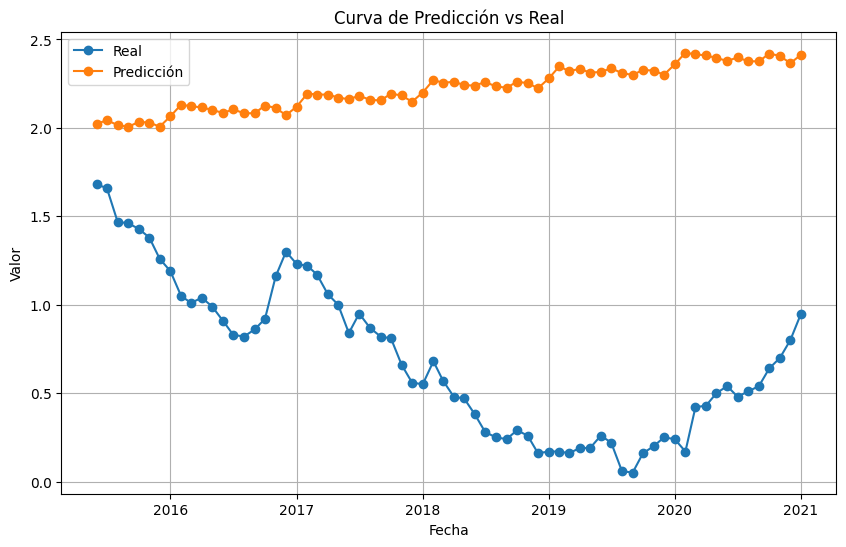

In [ ]:


# Graficar la curva de predicción versus la curva real
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Real', marker='o')
plt.plot(test['ds'], best_predictions, label='Predicción', marker='o')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Curva de Predicción vs Real')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Crear un modelo Prophet
model = Prophet()

# Dividir los datos en conjuntos de entrenamiento y prueba
train, test = train_test_split(vix_prophet, test_size=0.02, shuffle=False)

# Crear un modelo Prophet
model = Prophet()

# Ajustar el modelo solo al conjunto de entrenamiento
model.fit(train)

# Realizar predicciones en el conjunto de prueba
forecast = model.predict(test)

11:49:47 - cmdstanpy - INFO - Chain [1] start processing
11:49:47 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
prdc = pd.DataFrame()
prdc['date'] = forecast['ds']
prdc['value'] = forecast['yhat']

prdc

,date,value
0,2020-07-01,0.789801
1,2020-08-01,0.743282
2,2020-09-01,0.729546
3,2020-10-01,0.764805
4,2020-11-01,0.744141
5,2020-12-01,0.692852
6,2021-01-01,0.725937


In [ ]:
# Crear un DataFrame con las fechas a predecir (filas 336 a 340)
future = model.make_future_dataframe(periods=5)

# Realizar las predicciones
forecast = model.predict(future)

# Mostrar las predicciones para las filas 336 a 340
print(forecast[['ds', 'yhat']].tail())  # yhat contiene las predicciones

            ds       yhat
336 2021-01-02  14.655221
337 2021-01-03  13.445400
338 2021-01-04  12.719955
339 2021-01-05  12.497041
340 2021-01-06  12.779924
